In [1]:
import sys
import os
sys.path.append(os.getcwd()[:-8])

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
from ACME.ACME import ACME
import numpy as np
import pandas as pd

In [5]:
mean = [5,5,5,5,5,5]
cov = np.identity(6)
x_normal = pd.DataFrame(np.random.multivariate_normal(mean, cov, 5000), columns = ['f'+str(i) for i in range(1,7)] )
x_normal['is_out'] = 0

In [6]:
mean = [10,10,8,5,5,5]
cov = np.identity(6)
x_outliers =  pd.DataFrame(np.random.multivariate_normal(mean, cov, 200), columns = ['f'+str(i) for i in range(1,7)] )
x_outliers['is_out'] = 1

In [7]:
X = pd.concat([x_normal,x_outliers],ignore_index=True, sort=False).reset_index(drop=True)

In [8]:
features = ['f'+str(i) for i in range(1,7)]

In [9]:
from sklearn.ensemble import IsolationForest
if_model = IsolationForest(random_state=0).fit(X[features])

In [10]:
X['pred_AD_score'] = if_model.decision_function(X[features])
X['pred_AD_score'] = -1*X['pred_AD_score']
X.tail()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5195,10.884144,10.454876,8.584779,4.638050,4.321893,3.875212,1,0.149969
5196,9.462275,8.306753,7.579772,4.973369,4.908904,4.559667,1,0.059218
5197,9.618311,11.861450,8.982186,5.647823,3.054265,5.423741,1,0.174691
5198,9.297856,9.952328,9.351485,4.279559,5.915304,4.705588,1,0.148283
5199,9.489075,9.810831,8.516120,5.843887,5.153333,4.806277,1,0.112447


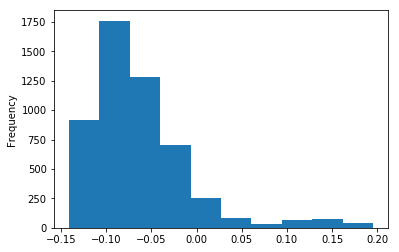

In [11]:
X['pred_AD_score'].plot(kind='hist')

In [12]:
bottom_anomalies = X.loc[(X['pred_AD_score']>0.01)].sort_values(by='pred_AD_score', ascending=False).tail(10)
top_anomalies = X.loc[(X['pred_AD_score']>0.01)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [13]:
top_normal = X.loc[(X['pred_AD_score']<0.01)].sort_values(by='pred_AD_score', ascending=False).tail(10)
bottom_normal = X.loc[(X['pred_AD_score']<0.01)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [14]:
top_anomalies

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
5091,10.813759,10.122959,10.283349,6.055534,7.725760,5.497232,1,0.195554
5044,12.677258,10.921653,9.279457,3.647099,5.214578,4.566586,1,0.193357
5028,10.664085,10.892152,9.648395,6.711730,3.407914,5.206252,1,0.192072
5060,9.807874,11.000843,8.515517,6.044806,2.284022,5.907369,1,0.186207
5129,11.735680,12.487471,8.644307,3.893807,4.260790,5.354625,1,0.183641
5099,9.345587,10.847893,10.212009,6.321615,6.388328,3.831624,1,0.183280
5176,10.941493,7.872885,10.078195,7.121009,5.647679,5.906138,1,0.182798
5139,12.332033,12.331100,7.413860,5.520774,3.585117,6.088656,1,0.182577
5171,11.347618,8.904368,9.115721,5.869791,3.545117,7.196226,1,0.182006
5037,10.446457,9.772727,10.386022,4.503162,7.234670,5.415518,1,0.181482


In [15]:
k = 20
def score_function(model, data):
    try: # for global
        df = model.decision_function(data)
    except: # for local
        df = model.decision_function(data.reshape(1,-1))
    
    return -1*df

acme_ifo = ACME(model = if_model, target = 'AD_score', K=k, task='ad', score_function=score_function, features=features)
acme_ifo = acme_ifo.fit(X[features], robust = True)

In [16]:
#acme_local = acme_ifo.fit_local(X[features], top_anomalies.index[-1])
acme_local = acme_ifo.fit_local(X[features], bottom_anomalies.index[-1])
#acme_local = acme_ifo.fit_local(X[features], top_normal.index[-1])
#acme_local = acme_ifo.fit_local(X[features], bottom_normal.index[-1])

In [17]:
local_table = acme_local.summary_table(local=True)

In [18]:
acme_local.feature_importance()

,importance
feature,
f2,0.031901
f1,0.031757
f3,0.026852
f4,0.024390
f5,0.018298
f6,0.013637


In [19]:
acme_local.feature_exploration('f3',local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile,size,direction
feature,,,,,,,,,
f3,0.035911,0.046125,0.010214,1.052898,0.000000,numeric,0.956538,0.1,anomalies
f3,-0.017198,-0.006984,0.010214,3.421418,0.055556,numeric,0.956538,0.1,normal
f3,-0.026065,-0.015851,0.010214,3.792494,0.111111,numeric,0.956538,0.1,normal
f3,-0.033845,-0.023631,0.010214,4.053024,0.166667,numeric,0.956538,0.1,normal
f3,-0.040715,-0.030501,0.010214,4.264405,0.222222,numeric,0.956538,0.1,normal
f3,-0.041369,-0.031155,0.010214,4.424455,0.277778,numeric,0.956538,0.1,normal
f3,-0.043304,-0.033090,0.010214,4.613468,0.333333,numeric,0.956538,0.1,normal
f3,-0.047149,-0.036935,0.010214,4.778503,0.388889,numeric,0.956538,0.1,normal
f3,-0.052529,-0.042315,0.010214,4.929267,0.444444,numeric,0.956538,0.1,normal


In [20]:
acme_local.feature_exploration('f1',local=True,plot=True)

In [21]:
acme_local.baseline_values()

,f1,f2,f3,f4,f5,f6
0,5.20699,5.210917,5.115823,4.999506,4.979652,5.020085


In [22]:
acme_local.summary_plot(local=True)

In [23]:
acme_local.summary_table(local=True)

,effect,predict,baseline_prediction,original,quantile,type_feature,baseline_quantile
feature,,,,,,,
f1,0.087326,0.087326,0.010214,0.810616,0.000000,numeric,0.422500
f1,0.043179,0.043179,0.010214,3.412570,0.055556,numeric,0.422500
f1,0.034919,0.034919,0.010214,3.781947,0.111111,numeric,0.422500
f1,0.020290,0.020290,0.010214,4.038799,0.166667,numeric,0.422500
f1,0.016787,0.016787,0.010214,4.253577,0.222222,numeric,0.422500
...,...,...,...,...,...,...,...
f6,0.011340,0.011340,0.010214,5.775069,0.777778,numeric,0.453654
f6,0.021369,0.021369,0.010214,5.984152,0.833333,numeric,0.453654
f6,0.028823,0.028823,0.010214,6.255901,0.888889,numeric,0.453654
